In [79]:
import PIL
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import os
import cv2
import pathlib

#### Eğitim ve test setlerinin kök dizinlerini belirtiyoruz

In [36]:
#train_data_dir = pathlib.Path(path="C:/Users/murat/Documents/tensorflow/datasets/standard_ocr_dataset/data/training_data")
#test_data_dir = pathlib.Path(path="C:/Users/murat/Documents/tensorflow/datasets/standard_ocr_dataset/data/testing_data")

train_data_dir = os.path.join(path="C:/Users/murat/Documents/tensorflow/datasets/standard_ocr_dataset/data/training_data")
test_data_dir = os.path.join(path="C:/Users/murat/Documents/tensorflow/datasets/standard_ocr_dataset/data/testing_data")

In [32]:
?os.path.join

Signature: os.path.join(path, *paths)
Docstring: <no docstring>
File:      c:\users\murat\anaconda3\lib\ntpath.py
Type:      function


#### Eğitim ve test setlerini ayırıyoruz.

In [33]:
batch_size = 36
img_height = 28
img_width = 28

In [34]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=train_data_dir,
    validation_split=0.2,
    subset="training",
    labels="inferred",
    seed=100,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 20628 files belonging to 36 classes.
Using 16503 files for training.


In [37]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=test_data_dir,
    validation_split=0.2,
    subset="validation",
    labels="inferred",
    seed=100,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1008 files belonging to 36 classes.
Using 201 files for validation.


#### Sınıf isimlerini alıyoruz

In [38]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


#### Fikir sahibi olmak için her sınıftan bir görseli ve etiketini görselleştiriyoruz.

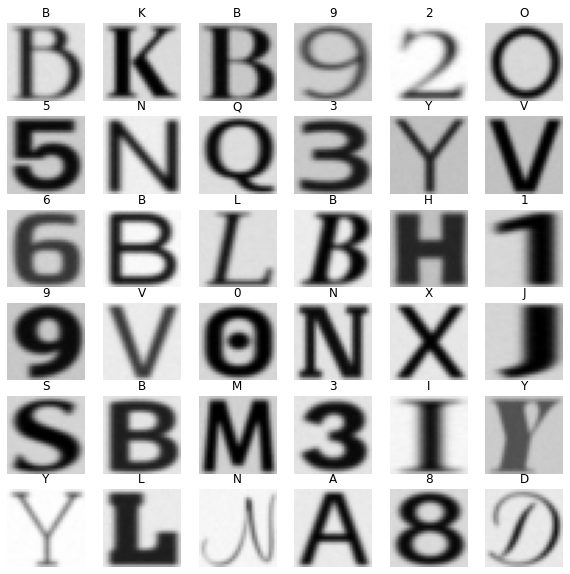

In [39]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(36):
        ax = plt.subplot(6, 6, i+1)
        plt.imshow(X=images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [40]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape, labels_batch.shape)
    break

(36, 28, 28, 3) (36,)


#### Veri setini sürekli local klasörden çağırmak yerine ön belleğe kaydedip oradan çağıracağız.

In [41]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### 0-255 arasında olan piksel değerlerini 0-1 aralığında ölçekliyoruz.

In [42]:
rescaling_layer = layers.Rescaling(1./255)

#### Daha genelleştirilebilir bir model için data augmentation işlemi yapacağız.

In [43]:
data_augmentation = keras.Sequential([
    layers.RandomFlip(mode="horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(factor=0.1),
    layers.RandomZoom(height_factor=0.1)
])

#### Modelimizi kuralım.

In [44]:
model = Sequential([
    data_augmentation,
    rescaling_layer,
    layers.Conv2D(filters=16, kernel_size=3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(units=128, activation="relu"),
    layers.Dense(units=36, name="outputs")
])

#### Modelimizi derleyelim.

In [45]:
model.compile(optimizer="adam", loss="mean_squared_error", metrics=["accuracy"])

In [46]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 28, 28, 3)         0         
                                                                 
 rescaling_1 (Rescaling)     (None, 28, 28, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                 

#### Modelimizi eğitelim.

In [47]:
epochs = 10
history = model.fit(train_ds, validation_data=test_ds, epochs=epochs)

Epoch 1/10
459/459 [==============================] - 10s 15ms/step - loss: 101.5047 - accuracy: 0.0246 - val_loss: 65.8989 - val_accuracy: 0.0100
Epoch 2/10
459/459 [==============================] - 7s 15ms/step - loss: 70.1782 - accuracy: 0.0203 - val_loss: 57.3306 - val_accuracy: 0.0050
Epoch 3/10
459/459 [==============================] - 7s 15ms/step - loss: 60.8117 - accuracy: 0.0208 - val_loss: 51.4792 - val_accuracy: 0.0149
Epoch 4/10
459/459 [==============================] - 7s 15ms/step - loss: 53.8133 - accuracy: 0.0224 - val_loss: 42.7377 - val_accuracy: 0.0249
Epoch 5/10
459/459 [==============================] - 7s 15ms/step - loss: 49.3478 - accuracy: 0.0259 - val_loss: 38.0327 - val_accuracy: 0.0050
Epoch 6/10
459/459 [==============================] - 7s 15ms/step - loss: 43.8849 - accuracy: 0.0240 - val_loss: 33.1017 - val_accuracy: 0.0348
Epoch 7/10
459/459 [==============================] - 7s 15ms/step - loss: 42.0543 - accuracy: 0.0218 - val_loss: 33.4331 - val_

#### Modelimizin sonuçlarını grafik üzerinde görelim.

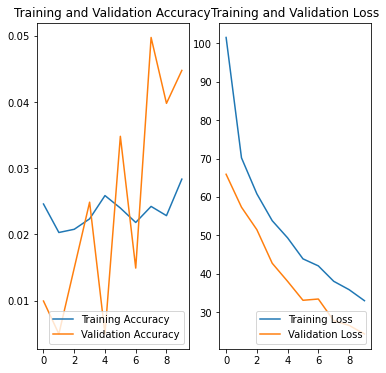

In [48]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="lower right")
plt.title("Training and Validation Loss")
plt.show();

#### Bir test verisi üzerinde tahmin işlemi yapalım.

In [83]:
img_path = os.path.join(path="C:/Users/murat/Documents/tensorflow/datasets/standard_ocr_dataset/data/testing_data/A")
img_name = os.listdir(img_path)[0]
imagePath = f"{img_path}/{img_name}"

img = tf.keras.utils.load_img(path=imagePath, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img=img)
img_array = tf.expand_dims(input=img_array, axis=0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(f"This image most likely belongs to {class_names[np.argmax(score)]} with a {100*np.max(score):.2f} percent confidence")

1/1 [==============================] - 0s 12ms/step
This image most likely belongs to I with a 4.80 percent confidence


In [82]:
img = cv2.imread(filename=imagePath)
cv2.imshow(winname="pred", mat=img)
cv2.waitKey(0)

-1

In [ ]:
?os.chdir

In [ ]:
?tf.keras.utils.image_dataset_from_directory